In [74]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set(style='white',palette=sns.cubehelix_palette(10, reverse=True))
from collections import Counter

In [75]:
sns.set(style='white',palette=sns.cubehelix_palette(10, reverse=True))

In [76]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
data = pd.concat([train,test], sort=False)
data = data.set_index('PassengerId')

## Data Overview

In [77]:
data.describe(include='all')

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,1309.000000,1309,1309,1046.000000,1309.000000,1309.000000,1309,1308.000000,295,1307
unique,NaN,NaN,1307,2,NaN,NaN,NaN,929,NaN,186,3
top,NaN,NaN,"Kelly, Mr. James",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S
freq,NaN,NaN,2,843,NaN,NaN,NaN,11,NaN,6,914
mean,0.383838,2.294882,NaN,NaN,29.881138,0.498854,0.385027,NaN,33.295479,NaN,NaN
std,0.486592,0.837836,NaN,NaN,14.413493,1.041658,0.865560,NaN,51.758668,NaN,NaN
min,0.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,0.000000,2.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1.000000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.275000,NaN,NaN


#### Distribution, Count

In [5]:
cat = ['Sex', 'Embarked']
discrete = ['SibSp', 'Parch', 'Pclass']
cont = ['Age','Fare']

## Distribution

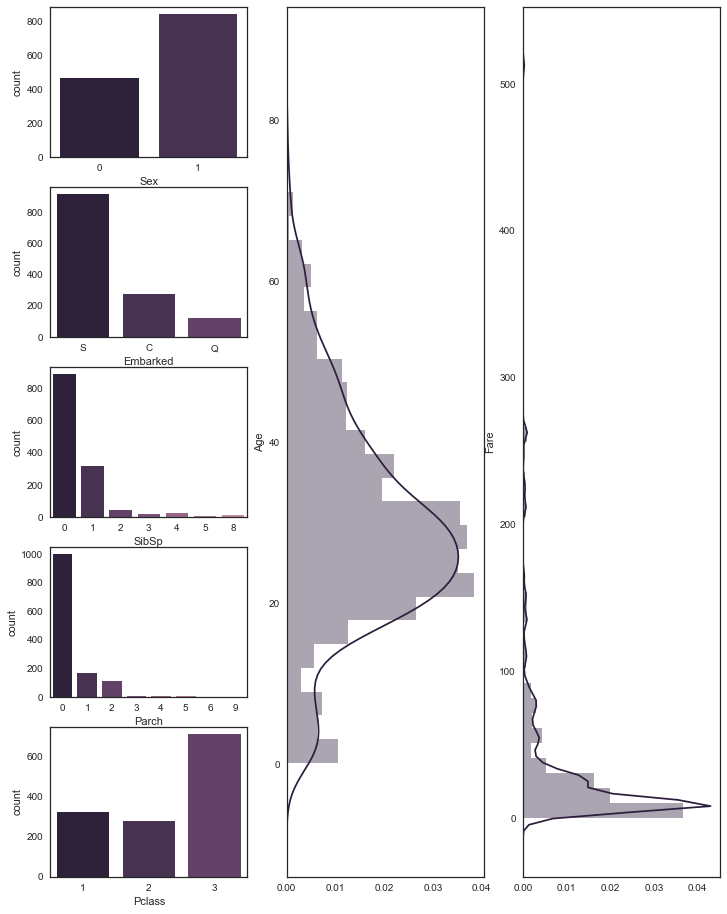

In [73]:
fig, axes = plt.subplots(5,3, figsize=(12,16))

for i, col in enumerate(cat+discrete):
    sns.countplot(data=data, x= col, ax=axes[i,0])

for i, col in enumerate(cont):
    plt.subplot2grid(shape=(5,3), loc=(0,i+1), rowspan=5, colspan=1, fig=fig)
    sns.distplot(data[data[col].notnull()][col], vertical=True)

## Relationship with Survived & Correlation

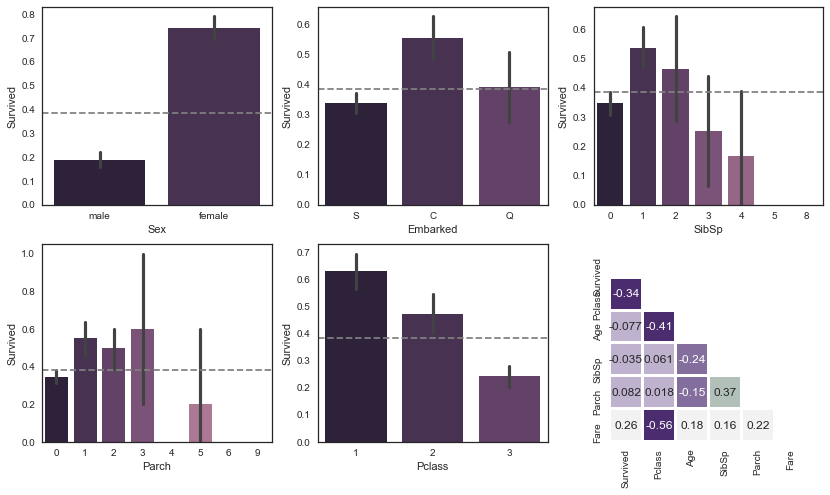

In [89]:
fig, axes = plt.subplots(2,3, figsize=(15,8))
for i, col in enumerate(cat+discrete):
    sns.barplot(data=data, x= col, y='Survived', ax=axes[i//3,i%3])
    axes[i//3,i%3].axhline(y=data.Survived.mean(), color='grey', linestyle='--')

mask = np.zeros_like(data.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data.corr(), annot=True, square=True, cbar=False,mask=mask,linewidth=2
            , cmap=sns.diverging_palette(280, 145, s=60, l=25, n=7), ax=axes[1,2])    

## Feature Engineering I

#### Sex 

In [8]:
data.Sex = data.Sex.map(lambda x: x=='male').astype('int')

#### Extracting Title, Surname from Name

In [9]:
def parse_surname(name):
    surname = name.split(', ')[0]
    title_name = name.split(', ')[1]
    title = title_name.split('. ')[0]
    return surname
def parse_title(name):
    surname = name.split(', ')[0]
    title_name = name.split(', ')[1]
    title = title_name.split('. ')[0]
    return title
data['Surname'] = data.Name.map(parse_surname)
data['Title'] = data.Name.map(parse_title)
Title_Dict = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Master", #Jonkheer means little girl
                    "Master" :    "Master", #Master means little boy
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Lady" :      "Royalty"
}
data.Title = data.Title.map(Title_Dict)

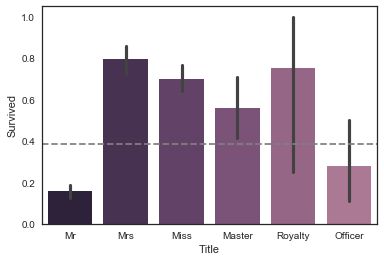

In [10]:
fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(data=data, x='Title', y='Survived')
plt.axhline(y=data.Survived.mean(), c='grey', linestyle='--')

#### Extracting (Labeling & Ordering) Family Size from Parch & SibSp
Ordering the Family_size by its influences to survival rate

In [11]:
data['Family_size'] = data.Parch + data.SibSp + 1

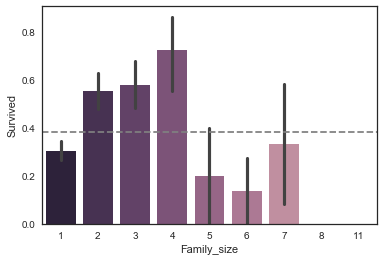

In [12]:
fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(data=data, x='Family_size', y='Survived')
plt.axhline(y=data.Survived.mean(), c='grey', linestyle='--')

In [13]:
# Ordering and Labeling its into 3 discrete values.
def fam_lab(x):
    if x>=2 and x<=4:
        return 2
    elif x==1 or (x>=5 and x<=7):
        return 1
    else:
        return 0
data['Family_size_label']=data.Family_size.map(fam_lab)

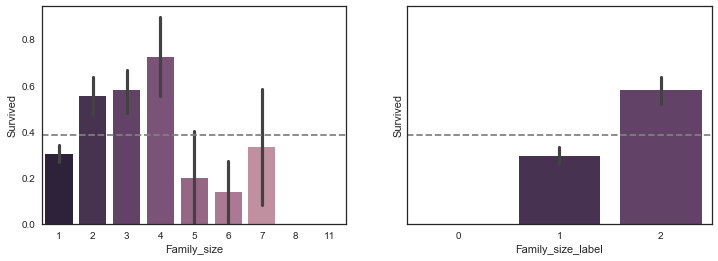

In [14]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(12,4))
for i, col in enumerate(['Family_size', 'Family_size_label']):
    sns.barplot(data=data, x=col, y='Survived', ax=axes[i])
    axes[i].axhline(y=data.Survived.mean(), c='grey', linestyle='--')

#### Filling & Parsing Cabin

In [15]:
data.Cabin = data.Cabin.fillna('U')

In [16]:
def parse_cabin(x):
    return x[0]

In [17]:
data.Cabin = data.Cabin.map(parse_cabin)

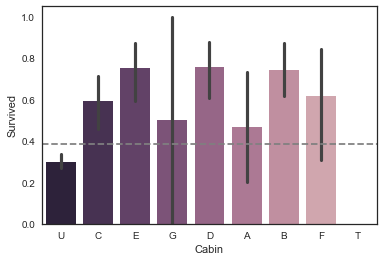

In [18]:
fig, ax = plt.subplots( figsize=(6,4))
sns.barplot(data=data, x='Cabin', y='Survived')
plt.axhline(y=data.Survived.mean(), c='grey', linestyle='--')

#### Parsing Ticket

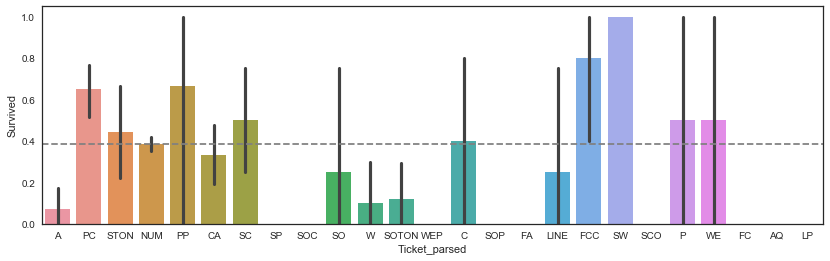

In [19]:
def parse_ticket(x):
    x = x.upper()
    if x.isnumeric():
        return 'NUM'
    else:
        x = x.split()[0]
        if '/' in x:
            x = x.split('/')[0]
        x = x.replace('.','')
        x = ''.join(map(str,[char for char in list(x) if char.isalpha()]))
        return x
data['Ticket_parsed'] = data.Ticket.map(parse_ticket)
fig, ax = plt.subplots(figsize=(14,4))
sns.barplot(data=data, x='Ticket_parsed', y='Survived')
plt.axhline(y=data.Survived.mean(), c='grey', linestyle='--')

#### Ticket Count

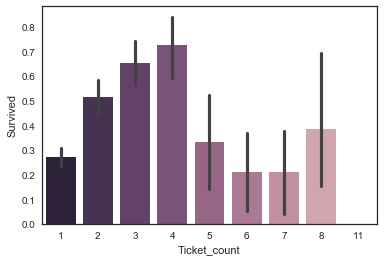

In [20]:
data['Ticket_count']=data.Ticket.map(Counter(data.Ticket))
sns.barplot(data=data, x='Ticket_count', y='Survived')

In [21]:
def ticket_lab(x):
    if x==2 or x==3 or x==4:
        return 2
    elif x == 1 or (x>=5 and x<=8):
        return 1
    else:
        return 0

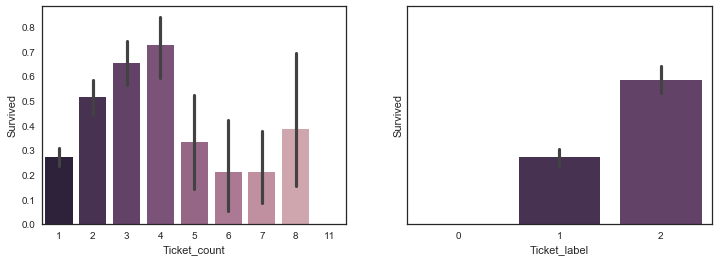

In [22]:
data['Ticket_label'] = data.Ticket_count.map(ticket_lab)
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(12,4))
sns.barplot(data=data, x='Ticket_count', y='Survived', ax=axes[0])
sns.barplot(data=data, x='Ticket_label', y='Survived', ax=axes[1])

## Filling Missing Value
some values need to be filled to deal with computing survival rate of certain groups

In [23]:
data.isnull().sum()[data.isnull().sum()!=0]

Survived    418
Age         263
Fare          1
Embarked      2
dtype: int64

### Missing Values - Fare

In [24]:
display(data[['Pclass','Fare']].groupby('Pclass').median())
data.loc[data.Fare.isnull(),'Fare'] = 8.05

,Fare
Pclass,
1,60.0000
2,15.0458
3,8.0500


## Missing Values - Embarked

In [25]:
display(data[data.Pclass==1].groupby('Embarked').median())
display(data[data.Embarked.isnull()])
data.loc[data.Embarked.isnull(),'Embarked']='C'

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Family_size,Family_size_label,Ticket_count,Ticket_label
Embarked,,,,,,,,,,,
C,1.0,1,0,39.0,0,0,76.7292,2,2,2,2
Q,0.5,1,0,37.0,1,0,90.0000,2,2,3,2
S,1.0,1,1,39.0,0,0,52.0000,1,1,2,2


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Title,Family_size,Family_size_label,Ticket_parsed,Ticket_count,Ticket_label
PassengerId,,,,,,,,,,,,,,,,,,
62,1.0,1,"Icard, Miss. Amelie",0,38.0,0,0,113572,80.0,B,NaN,Icard,Miss,1,1,NUM,2,2
830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",0,62.0,0,0,113572,80.0,B,NaN,Stone,Mrs,1,1,NUM,2,2


## Fill Cabin

In [26]:
# It has been done in Feature Engineering Session

#### Adjusting Fare, Fare/Ticket Count

In [27]:
# fig, axes = plt.subplots(2, 1, figsize=(15,7))
# sns.distplot(data.Fare.values, ax=axes[0])
# data.Fare = data.Fare/data.Ticket_count
# sns.distplot(data.Fare.values, ax=axes[1])

## Fill Age

In [28]:
pd.get_dummies(data[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Cabin', 'Embarked','Title', 'Family_size',
       'Family_size_label', 'Ticket_parsed', 'Ticket_count', 'Ticket_label']]).shape

check_corr = pd.get_dummies(data[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Cabin', 'Embarked','Title', 'Family_size',
       'Family_size_label', 'Ticket_parsed', 'Ticket_count', 'Ticket_label']])
check_corr = check_corr.corr()['Age'].drop('Age')

check_corr = check_corr.sort_values().map(lambda x: 0 if abs(x)<0.15 else x)
check_corr = check_corr[abs(check_corr) >= 0.15]

Text(0.5,0.98,'Correlation with Age')

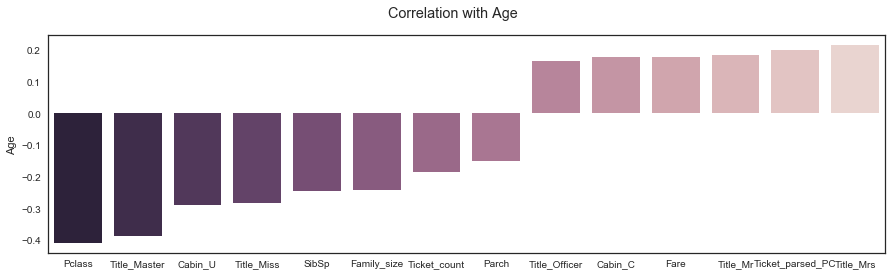

In [29]:
fig, ax = plt.subplots(figsize=(15,4))
sns.barplot(x=check_corr.index, y=check_corr, palette=sns.cubehelix_palette(14, reverse=True))
plt.suptitle("Correlation with Age")

In [30]:
feat_to_age = list(check_corr.index)

Text(0.5,0.98,'Before & After Filled')

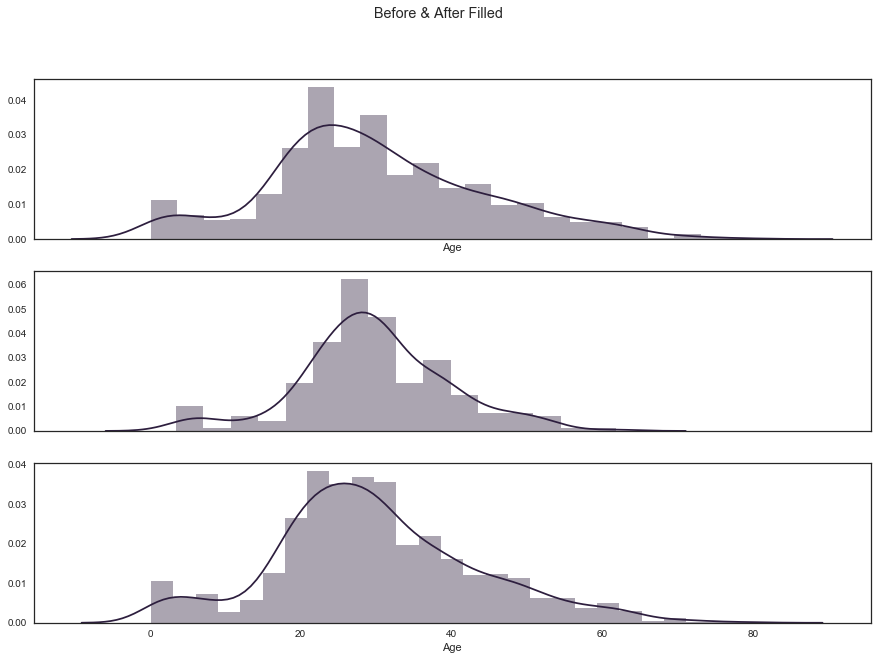

In [31]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(15,10))
sns.distplot(data[data['Age'].notnull()]['Age'], ax=axes[0])

ok_index = data.Age.notnull()
null_index = data.Age.isnull()
from sklearn.ensemble import RandomForestRegressor
rgr = RandomForestRegressor()
age_data = data[['Pclass','Title','Cabin','SibSp','Family_size','Ticket_count','Parch','Fare','Ticket_parsed','Age']]
age_data = pd.get_dummies(age_data)
age_data = age_data[feat_to_age+['Age']]
rgr.fit(X = age_data[ok_index].drop(columns='Age'), y = age_data[ok_index].Age)
y_pred = rgr.predict(age_data[null_index].drop(columns='Age'))
data.loc[null_index,'Age'] = y_pred 
sns.distplot(y_pred, ax=axes[1])
del ok_index, null_index, rgr, age_data, y_pred

sns.distplot(data.Age, ax=axes[2])
plt.suptitle('Before & After Filled')

## Feature Engineering II

In [32]:
# from sklearn.preprocessing import LabelEncoder
# def label(values):
#     encoder = LabelEncoder()
#     return encoder.fit_transform(values) + 1
# surname_list = data.Surname.unique()
# data['Surname_sub'] = np.nan
# for surname in surname_list:
#     buffer = data[data.Surname==surname].sort_values('Ticket')['Ticket']
#     tag = lambda x: 'single' if list(label(buffer)).count(x)==1 else 'family'
#     sub = [str(surname)+'_'+tag(num)+'_'+str(num) for num in label(buffer)]
#     data.loc[buffer.index,'Surname_sub'] = sub
# del buffer, tag, sub

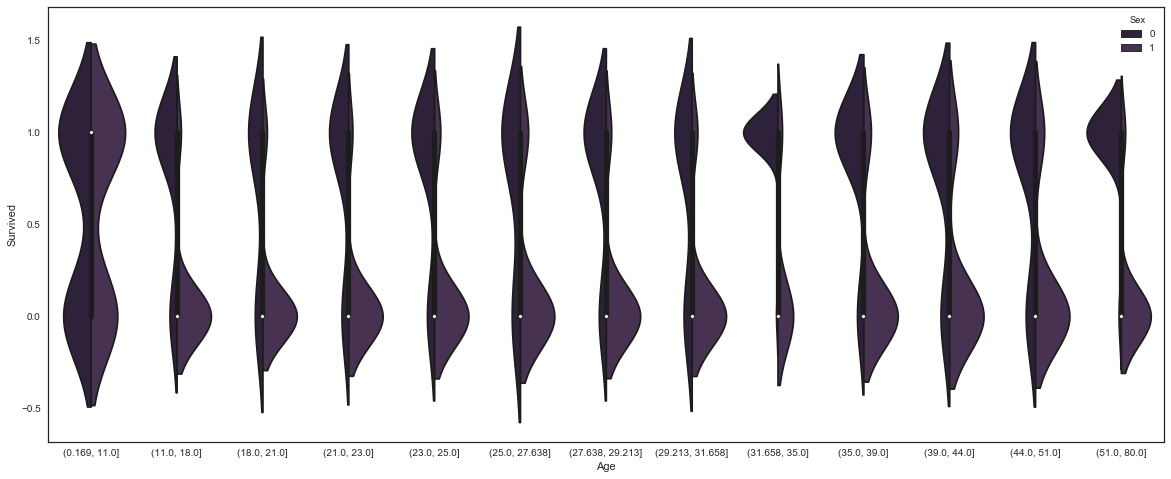

In [33]:
fig, ax = plt.subplots(figsize=(20,8))
sns.violinplot(data=data, x=pd.qcut(data.Age, 13), y='Survived', hue='Sex', split=True)

According to the above graph, it is shown that only kids' survival rates aren't affected by their genders.

#### Adding Child-Women & Male survival rate in Same Ticket

In [34]:
# data['Surname_count'] = data.Surname.map(data.Surname.value_counts())

In [35]:
# c_w = data[(data.Surname_count >= 2) & ((data.Age<=12)|(data.Sex == 0))]
# male = data[(data.Surname_count >= 2) & ((data.Age>12)&(data.Sex == 1))]

In [36]:
# obs_c_w = c_w.groupby('Surname')['Survived'].mean().value_counts()
# obs_male = male.groupby('Surname')['Survived'].mean().value_counts()

In [37]:
# fig, axes = plt.subplots(1, 2,figsize=(16,4))
# sns.barplot(x=obs_c_w.index, y=obs_c_w.values, ax=axes[0])
# sns.barplot(x=obs_male.index, y=obs_male.values, ax=axes[1])
# plt.suptitle('Child-Women Group & Male Group')

In [38]:
# c_w_dead = (c_w.Survived == 0)
# c_w_dead = c_w_dead[c_w_dead.index>890].index
# male_alive = (male.Survived == 0)
# male_alive = male_alive[male_alive.index>890].index

In [39]:
c_w = data[(data.Ticket_count >= 2) & ((data.Age<=12)|(data.Sex == 0))]
male = data[(data.Ticket_count >= 2) & ((data.Age>12)&(data.Sex == 1))]

In [40]:
obs_c_w = c_w.groupby('Ticket')['Survived'].mean().value_counts()
obs_male = male.groupby('Ticket')['Survived'].mean().value_counts()

Text(0.5,0.98,'Child-Women Group & Male Group')

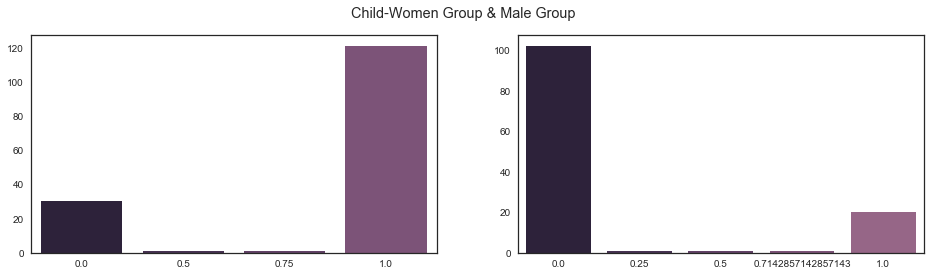

In [41]:
fig, axes = plt.subplots(1, 2,figsize=(16,4))
sns.barplot(x=obs_c_w.index, y=obs_c_w.values, ax=axes[0])
sns.barplot(x=obs_male.index, y=obs_male.values, ax=axes[1])
plt.suptitle('Child-Women Group & Male Group')

In [42]:
c_w_dead = (c_w.Survived == 0)
c_w_dead = c_w_dead[c_w_dead.index>890].index
male_alive = (male.Survived == 1)
male_alive = male_alive[male_alive.index>890].index

It's shown that group of Child-Women and group of Male are normally dead or alive together. 
And the survial rate of Child-Women and Males in Ticket Group can absolutely predict the others group members' survival.

In [43]:
# def parse_sur(x):
#     if x>=0 and x<0.5:
#         return 0
#     elif x==0.5:
#         return 0.5
#     elif x>0.5:
#         return 1
#     else:
#         return x
# c_w_dict = c_w.groupby('Ticket')['Survived'].mean()
# c_w_dict = c_w_dict.map(parse_sur).to_dict()
# male_dict = male.groupby('Ticket')['Survived'].mean()
# male_dict = male_dict.map(parse_sur).to_dict()

# data['Ticket_survival']=data.Ticket
# data.loc[c_w.index,'Ticket_survival'] = data.loc[c_w.index,'Ticket_survival'].map(c_w_dict)
# data.loc[male.index,'Ticket_survival'] = data.loc[male.index,'Ticket_survival'].map(male_dict)

# def parse_sur(x):
#     if isinstance(x, str):
#         return np.nan
#     else:
#         return x
# data.Ticket_survival = data.Ticket_survival.map(parse_sur)

#### Dummies & Finalizing Dataset

In [44]:
df = data[['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Cabin', 'Embarked','Title', 'Family_size_label', 'Ticket_label', 'Ticket_parsed']]

In [45]:
df = pd.get_dummies(df)

In [46]:
X = df[:891].drop(columns='Survived')
y = df[:891].Survived
test = df[891:].drop(columns='Survived')

#### Overall Correlation

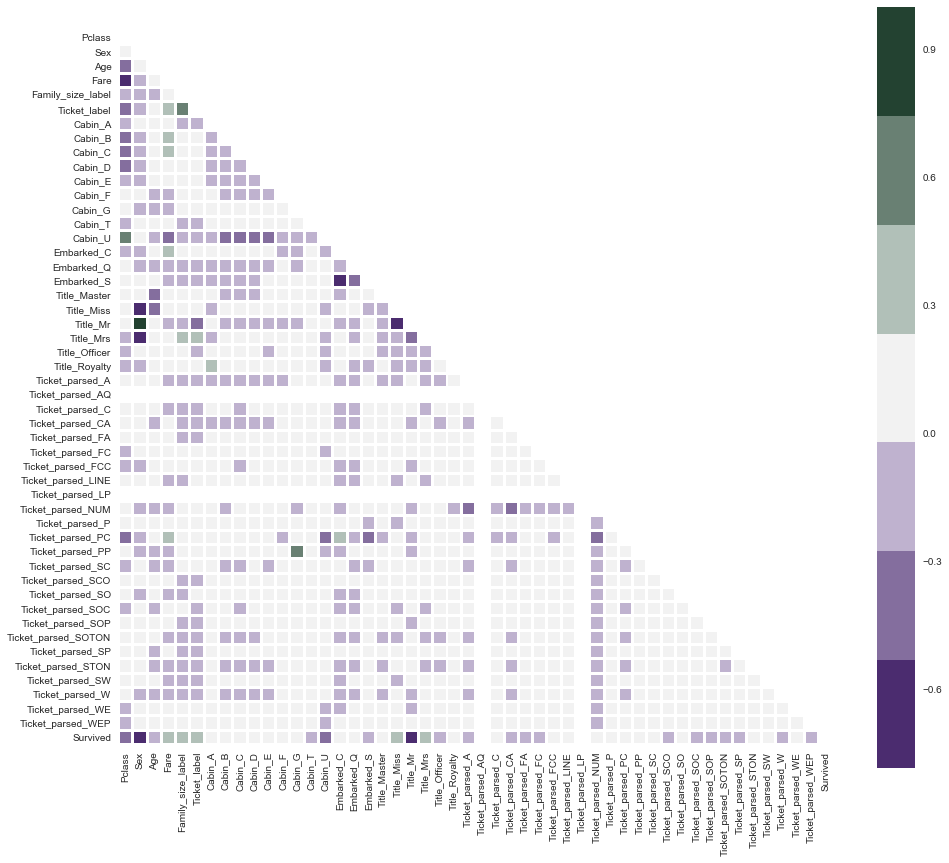

In [62]:
corr = pd.concat([X,y], axis=1).corr()
fig, ax = plt.subplots(figsize=(16,14))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, square=True, mask = mask ,linewidths=2
            ,cmap=sns.diverging_palette(280, 145, s=60, l=25, n=7), ax=ax)

#### Training & Predicting

In [48]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' ## prevent xgboost causing kernel dead

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.pipeline import make_pipeline
from skopt import BayesSearchCV
from sklearn.feature_selection import SelectKBest

In [49]:
pipelines = {
    'rf':make_pipeline(SelectKBest(),RandomForestClassifier(verbose=False)),
    'xg':make_pipeline(SelectKBest(),XGBClassifier(verbose=False)),
    'lr':make_pipeline(SelectKBest(),LogisticRegression(verbose=False)),
    'kn':make_pipeline(SelectKBest(),KNeighborsClassifier()),
}

In [50]:
rf_hyperparameters = {
    'selectkbest__k': (20,49),
    'randomforestclassifier__max_depth': (3,10),
    'randomforestclassifier__n_estimators': (10,30),
}
xg_hyperparameters = {
    'selectkbest__k': (20,49),
    'xgbclassifier__learning_rate': (0.01, 1.0, 'log-uniform'),
    'xgbclassifier__max_depth': (0, 50),
    'xgbclassifier__n_estimators': (50, 200),
}
lr_hyperparameters ={
    'selectkbest__k': (20,49),
    'logisticregression__solver': ['liblinear', 'saga'],  
    'logisticregression__penalty': ['l1','l2'],
    'logisticregression__tol': (1e-5, 1e-3, 'log-uniform'),
    'logisticregression__C': (1e-5, 100, 'log-uniform'),
    'logisticregression__fit_intercept': [True, False]
}
kn_hyperparameters = {
    'selectkbest__k': (20,49),
    'kneighborsclassifier__n_neighbors': (5,15),
}

In [51]:
hyperparameters = {
    'rf':rf_hyperparameters,
    'xg':xg_hyperparameters,
    'lr':lr_hyperparameters,
    'kn':kn_hyperparameters,
}

In [52]:
cv = StratifiedKFold(y, n_folds=10)
fitted_model = {}
for name, pipeline in pipelines.items():
    search = BayesSearchCV(pipeline, search_spaces=hyperparameters[name], cv=10, n_jobs=-1, verbose=False)
    search.fit(X,y)
    fitted_model[name] = search
    print('{} model is done'.format(name))

rf model is done
xg model is done
lr model is done
kn model is done


In [53]:
names = list(fitted_model.keys())
model_scores = [model.best_score_ for model in fitted_model.values()]

In [54]:
model_scores

[0.8428731762065096,
 0.8372615039281706,
 0.8103254769921436,
 0.7295173961840629]

Text(0.5,0.98,'Best Scores across models')

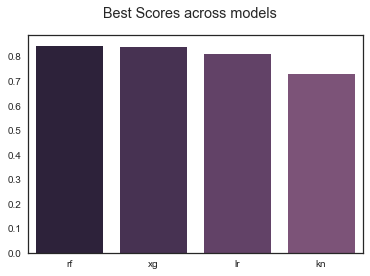

In [55]:
plot = sns.barplot(x=names, y=model_scores)
plt.suptitle('Best Scores across models')

### Prediction

In [56]:
test.loc[male_alive,['Sex','Age','Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
                     'Title_Officer', 'Title_Royalty']]= [1, 60, 0, 0, 1, 0, 0, 0]

In [57]:
test.loc[c_w_dead,['Sex','Age','Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
                     'Title_Officer', 'Title_Royalty']]= [0, 5, 0, 1, 0, 0, 0, 0]

In [58]:
y_pred = fitted_model['rf'].predict(test).astype('int')

#### Submission 

In [59]:
submission = pd.read_csv('gender_submission.csv')
submission.Survived = y_pred

In [60]:
submission.to_csv('submission.csv', index=False)

In [61]:
#Score: 0.80382